In [1]:
import torch as th
import torch.nn as nn
from torchvision import transforms
import torchvision as thv
import os

## Modèle

In [2]:
class SimpleConvModel(nn.Module):
    def __init__(self, out_channel_conv=16, linear_hidden_size=256, out_class=13):
        super(SimpleConvModel, self).__init__()
        
        self.out_channel_conv = out_channel_conv
        self.linear_hidden_size = linear_hidden_size
        self.out_class = out_class
        
        self.seq1 = nn.Sequential(nn.Conv2d(3, self.out_channel_conv, (10,10), stride=(3,3)),
                                  nn.MaxPool2d((5,5)),
                                  nn.ReLU())
        
        self.seq2 = nn.Sequential(nn.Linear(16 * 16 * 16, self.linear_hidden_size),
                                  nn.ReLU(),
                                  nn.Linear(self.linear_hidden_size, self.out_class),
                                  nn.Softmax(dim = 1)) 
        
    def forward(self, x):
        out1 = self.seq1(x)
        out2 = out1.view(-1, 16*16*16)
        out3 = self.seq2(out2)
        return out3

## Chargement des données

In [3]:
data_dir = "RESISC13"
batch_size = 32
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
scale = 360
use_parallel = True

data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)])

In [4]:
to_load = ['train', 'val', 'test']

In [5]:
image_datasets = {x: thv.datasets.ImageFolder(os.path.join(data_dir, x),
                                      data_transforms) for x in to_load}
dataloaders = {x: th.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                         shuffle=True, num_workers=4) for x in to_load}

In [6]:
use_cuda = True

In [11]:
nb_epoch = 100

model = SimpleConvModel()
loss_fn = nn.CrossEntropyLoss()

if use_cuda:
    model.cuda()
    loss_fn.cuda()
    
optim = th.optim.Adagrad(model.parameters(), lr=5e-4)

loss_values = []
acc_values = []

for e in range(nb_epoch):
    model.train()
    
    sum_loss = 0
    total = 0
    for x, y in dataloaders['train']:
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        
        optim.zero_grad()
        
        out = model(x)
        loss = loss_fn(out, y)
        
        loss.backward()
        optim.step()
        
        sum_loss += loss.item()
        total += 1
    sum_loss /= total
    
    model.eval()
    sum_acc = 0
    total = 0
    for x, y in dataloaders['val']:
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        pred = model(x).argmax(dim=1)
        sum_acc += th.sum(pred == y).item() / x.size(0)
        total += 1
    sum_acc /= total
    
    loss_values.append(sum_loss)
    acc_values.append(sum_acc)
    print("Epoch %d, loss = %f, acc = %f" % (e, sum_loss, sum_acc))    

Epoch 0, loss = 2.456619, acc = 0.249624
Epoch 1, loss = 2.388986, acc = 0.308777
Epoch 2, loss = 2.353087, acc = 0.377493
Epoch 3, loss = 2.314221, acc = 0.400478
Epoch 4, loss = 2.288809, acc = 0.469262
Epoch 5, loss = 2.266902, acc = 0.475854
Epoch 6, loss = 2.251912, acc = 0.476332
Epoch 7, loss = 2.239502, acc = 0.484085
Epoch 8, loss = 2.227113, acc = 0.476264
Epoch 9, loss = 2.215233, acc = 0.503176
Epoch 10, loss = 2.204795, acc = 0.503518
Epoch 11, loss = 2.195599, acc = 0.512022
Epoch 12, loss = 2.188438, acc = 0.505294
Epoch 13, loss = 2.181731, acc = 0.510383
Epoch 14, loss = 2.176160, acc = 0.519126
Epoch 15, loss = 2.170711, acc = 0.512807
Epoch 16, loss = 2.166123, acc = 0.512432
Epoch 17, loss = 2.161022, acc = 0.518033
Epoch 18, loss = 2.156895, acc = 0.513866
Epoch 19, loss = 2.152634, acc = 0.516803
Epoch 20, loss = 2.149387, acc = 0.517896
Epoch 21, loss = 2.146070, acc = 0.521414
Epoch 22, loss = 2.142053, acc = 0.523975
Epoch 23, loss = 2.139037, acc = 0.523600
Ep

In [12]:
import matplotlib.pyplot as plt

No handles with labels found to put in legend.


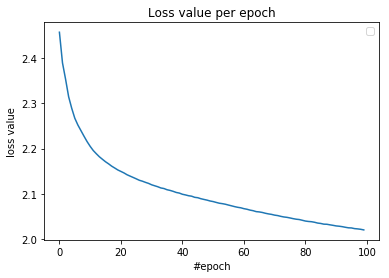

In [15]:
plt.plot(range(nb_epoch), loss_values)
plt.xlabel("#epoch")
plt.ylabel("loss value")
plt.title("Loss value per epoch")
plt.legend()
plt.show()

No handles with labels found to put in legend.


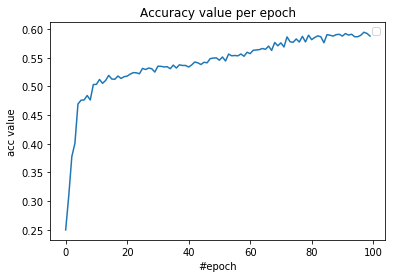

In [16]:
plt.plot(range(nb_epoch), acc_values)
plt.xlabel("#epoch")
plt.ylabel("acc value")
plt.title("Accuracy value per epoch")
plt.legend()
plt.show()